# Data Preprocessing and Library loading:

In [73]:
import json, sys, time, os, copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas
import pickle

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, roc_auc_score

plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")

In [5]:
jsonDir = "./jsonFiles"

fullTestSet = np.load("fullTestSet.npy")
errMSE = np.load("ERROR_MAE_3D_T1.npy")
with open(os.path.join(jsonDir,"file_list_3D_MAE.json"),"r") as f:
    fileList = json.load(f)

fileList = [x[:-8] for x in fileList]

print("Number of Files: ", len(fileList))

Number of Files:  31199


In [7]:
# Flattening Error volume 8x7x7 for RF

errFlat = np.zeros((errMSE.shape[0],errMSE.shape[1]*errMSE.shape[2]*errMSE.shape[3]))

for i in range(errMSE.shape[0]):
    errFlat[i] = errMSE[i,:,:,:].flatten()

print("Pre Flatten {} vs. Flattened {}".format(errMSE.shape,errFlat.shape))

Pre Flatten (31199, 8, 7, 7) vs. Flattened (31199, 392)


In [8]:
# Load in tags and additional meta data:

with open(os.path.join(jsonDir,"./reasons_split.json"),"r") as f: # Tags
    tagDict = json.load(f)

with open(os.path.join(jsonDir,"biobank_meta_float.json"),"r") as f: # Float meta data from dcm headers
    metaDict = json.load(f)

with open(os.path.join(jsonDir,"Biobank_Bounding_Boxes.json"),"r") as f: # Bounding box meta data
    bBoxes = json.load(f)

In [10]:
# Sort through subj to make sure all meta data present

keys = list(metaDict.keys())
keys = [k for k in keys if k in bBoxes.keys()]
keys = [k for k in keys if k in fileList]

print("Number of Files with complete meta data: ", len(keys))

Number of Files with complete meta data:  31199


In [17]:
# Find out the keys present in every single case:

allMetaKeys = []
instTime = ["1","2","3","4","5","6","7"]
for k in keys:
    for i in instTime:
        allMetaKeys.extend(list(metaDict[k][i].keys()))

allMetaKeysSet = set(allMetaKeys)

keysOI = []
for k in allMetaKeysSet:
    if allMetaKeys.count(k) == (len(keys)*7):
        keysOI.append(k)

print("Meta values to use: \n\n", keysOI)


Meta values to use: 
 ['Magnetic Field Strength', 'Number of Phase Encoding Steps', 'Echo Train Length', 'Flip Angle', 'Echo Number(s)', 'Samples per Pixel', '[RealDwellTime]', 'Rows', 'Number of Averages', 'Content Date', 'Study Date', 'Acquisition Number', 'Bits Stored', 'Largest Image Pixel Value', '[CSA Image Header Version]', 'Pixel Representation', 'Columns', "Patient's Birth Date", 'Pixel Bandwidth', '[SliceMeasurementDuration]', 'dB/dt', 'Bits Allocated', 'Percent Sampling', 'Imaging Frequency', 'Echo Time', '[CSA Series Header Version]', 'Window Width', 'Acquisition Date', 'Content Time', 'Repetition Time', 'Window Center', 'SAR', 'Acquisition Time', 'Slice Thickness', '[CSA Image Header Version ??]', 'Instance Creation Time', '[TimeAfterStart]', 'Smallest Image Pixel Value', 'Device Serial Number', 'Series Time', '[SliceResolution]', "Patient's Weight", 'High Bit', "Patient's Size", 'Instance Creation Date', 'Series Number', 'Instance Number', 'Inversion Time', 'Slice Locatio

In [18]:
# Create dataset:

subjLength = len(keys)
dataLength = len(keysOI)
bBoxesLength = 16
errLength = errFlat.shape[1]

ownDataset = np.zeros((subjLength,dataLength*len(instTime) + bBoxesLength + errLength))

k0 = list(tagDict.keys())[0]
tags = np.zeros((subjLength,len(tagDict[k0])))

for i,k in enumerate(keys):
    sys.stdout.write("\r[{}/{}]".format(i,len(keys)))
    metaList = []
    for kOI in keysOI:
        for inst in instTime:
            metaList.append(metaDict[k][inst][kOI])
    try:
        metaList.extend(bBoxes[k]["Body"])
    except KeyError as e:
        metaList.extend([0,0,0,0])

    try:
        metaList.extend(bBoxes[k]["Liver"])
    except KeyError as e:
        metaList.extend([0,0,0,0])

    try:
        metaList.extend(bBoxes[k]["Lungs"])
    except KeyError as e:
        metaList.extend([0,0,0,0])

    try:
        metaList.extend(bBoxes[k]["Heart"])
    except KeyError as e:
        metaList.extend([0,0,0,0])

    charArr = np.char.find(fileList,k)
    charIdx = np.argwhere(charArr == 0)[0,0]
    
    assert(type(charIdx) == np.int64)
    errMeta = list(errFlat[charIdx,:])

    metaList.extend(errMeta)

    ownDataset[i,:] = np.array(metaList)
    if k in tagDict.keys():
        tags[i] = np.array(tagDict[k])

ownDataset = (ownDataset,tags)

print("Meta Data for Subj0: {} \n Tag for Subj0: {}".format(ownDataset[0][0][:10],ownDataset[1][0]))

[31198/31199]Meta Data for Subj0: [  1.5   1.5   1.5   1.5   1.5   1.5   1.5 107.  107.  107. ] 
 Tag for Subj0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [22]:
print("Header Meta Data: {} \nBounding Box Meta Data: {} \nImage Recon Errors: {} \n".format(dataLength*len(instTime),bBoxesLength,errLength))

Header Meta Data: 364 
Bounding Box Meta Data: 16 
Image Recon Errors: 392 



# Train Random Forests:

## All Data:

In [23]:
# Hyperparameters:

testSize = 0.5
n_estimators = 100
max_depth = 10
tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']
numAvgs = np.arange(0,20,1)


In [99]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,:]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [100]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.733108     0.999629         0.848765        0.806725   
std     0.008100     0.000049         0.007552        0.019000   
min     0.715292     0.999526         0.837470        0.767197   
25%     0.729445     0.999592         0.844796        0.796796   
50%     0.733473     0.999635         0.847135        0.805134   
75%     0.736590     0.999666         0.852243        0.822678   
max     0.747755     0.999697         0.868117        0.845563   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.776874   0.923274        0.900989   0.816553   0.911920   
std           0.028359   0.001948        0.003642   0.010184   0.004091   
min           0.708507   0.919127        0.893532   0.798068   0.905156   
25%           0.758719   0.922

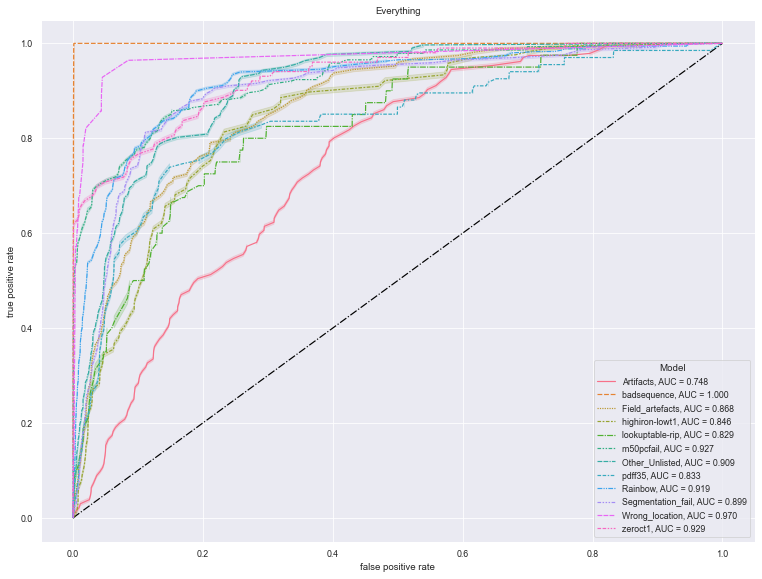

In [101]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Everything")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [102]:
# Save Models
saveDir = "./models/Random Forests/All_Meta/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Meta + Bboxes:

In [85]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,:-errLength]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [86]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.608334     0.999681         0.802650        0.540251   
std     0.013140     0.000039         0.004307        0.023043   
min     0.581741     0.999617         0.792186        0.502686   
25%     0.601251     0.999651         0.799517        0.526358   
50%     0.608277     0.999678         0.803325        0.533671   
75%     0.617099     0.999709         0.805643        0.553942   
max     0.627744     0.999763         0.810650        0.596700   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.735838   0.718306        0.652945   0.736511   0.881815   
std           0.018565   0.007129        0.010890   0.008677   0.006605   
min           0.699855   0.705345        0.636058   0.723620   0.866159   
25%           0.723462   0.715

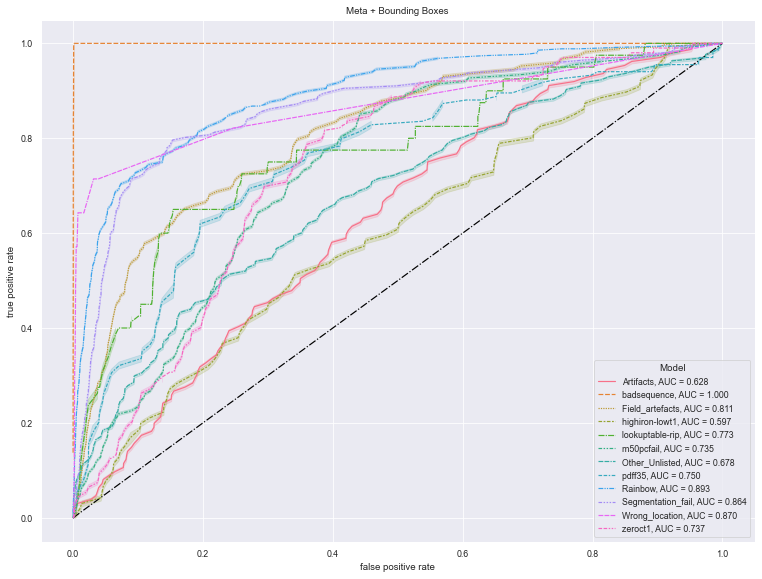

In [87]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Meta + Bounding Boxes")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [89]:
# Save Models
saveDir = "./models/Random Forests/Meta_BBoxes/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Meta Only:

In [90]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,:-(bBoxesLength+errLength)]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [91]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.596897     0.999686         0.798406        0.512524   
std     0.015613     0.000038         0.005437        0.014141   
min     0.572800     0.999617         0.787383        0.488939   
25%     0.585390     0.999664         0.795549        0.501236   
50%     0.595425     0.999694         0.797304        0.510666   
75%     0.610290     0.999707         0.802355        0.522238   
max     0.626584     0.999749         0.807569        0.538481   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.721570   0.680047        0.626195   0.702764   0.870227   
std           0.016587   0.009531        0.013034   0.007852   0.005408   
min           0.684793   0.656950        0.604273   0.688712   0.861202   
25%           0.708557   0.675

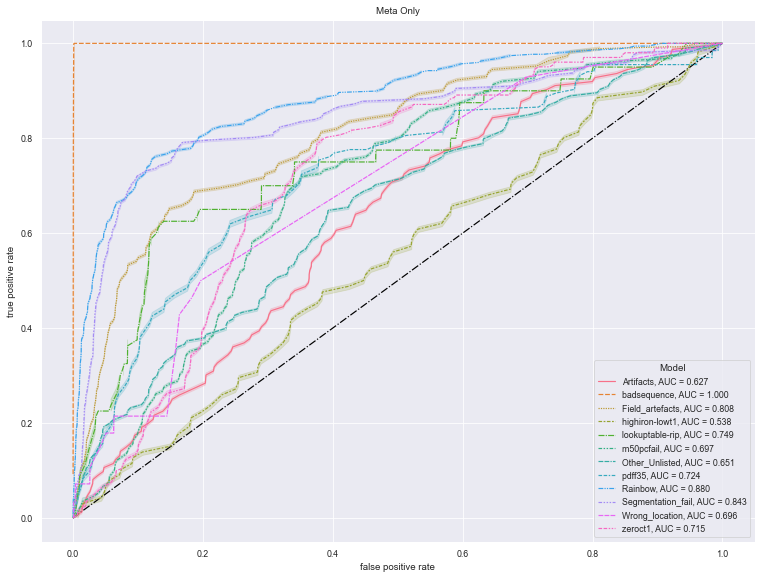

In [93]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Meta Only")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [94]:
# Save Models
saveDir = "./models/Random Forests/Meta_Only/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Error Only: 

In [95]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,-errLength:]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [96]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.740917     0.998295         0.851981        0.843396   
std     0.008538     0.000052         0.007878        0.017511   
min     0.720690     0.998208         0.836361        0.800789   
25%     0.734468     0.998250         0.847383        0.833479   
50%     0.742481     0.998288         0.851440        0.846751   
75%     0.744790     0.998336         0.859833        0.858066   
max     0.755044     0.998387         0.866098        0.866117   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.814070   0.913591        0.905944   0.834663   0.901582   
std           0.017188   0.002595        0.003783   0.014453   0.004205   
min           0.779444   0.909526        0.896727   0.808569   0.893793   
25%           0.803518   0.912

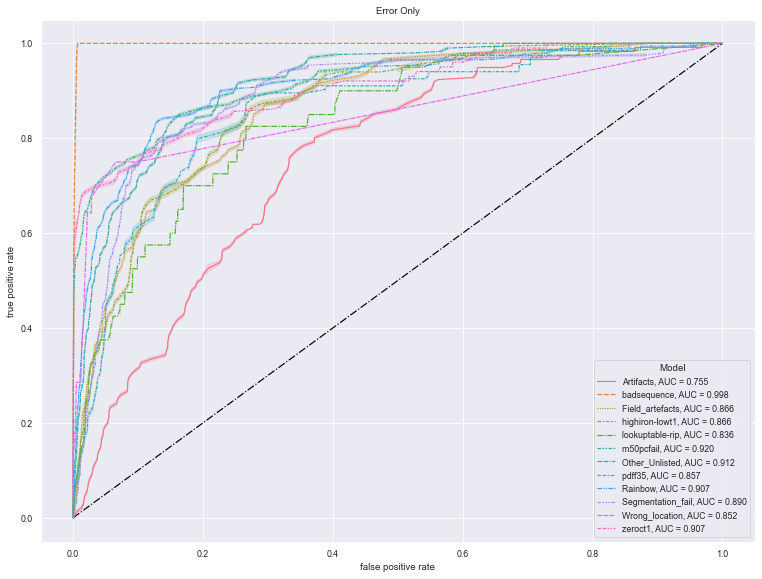

In [97]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Error Only")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [98]:
# Save Models
saveDir = "./models/Random Forests/Error_Only/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Error + BBoxes:

In [106]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,-(bBoxesLength+errLength):]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [107]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.740391     0.998787         0.848868        0.841339   
std     0.009110     0.000057         0.006635        0.014212   
min     0.726011     0.998667         0.837936        0.795488   
25%     0.733147     0.998738         0.844242        0.837106   
50%     0.739315     0.998800         0.848102        0.842556   
75%     0.747877     0.998835         0.853124        0.849391   
max     0.762089     0.998854         0.861622        0.862431   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.802669   0.917301        0.907133   0.833367   0.905566   
std           0.021188   0.002679        0.004593   0.012461   0.004318   
min           0.762130   0.910963        0.898223   0.802343   0.897489   
25%           0.788594   0.915

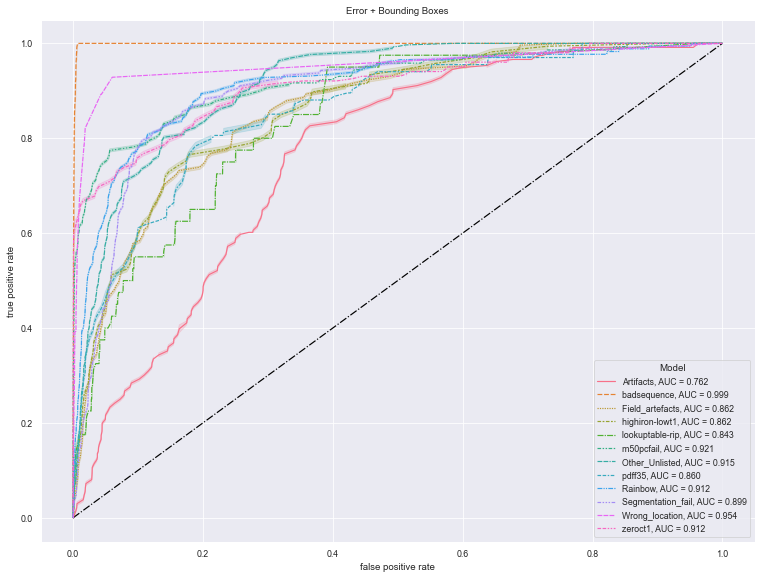

In [108]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Error + Bounding Boxes")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [109]:
# Save Models
saveDir = "./models/Random Forests/Error_BBoxes/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

# AUC Comparisons:

                   All_Meta  Error_BBoxes  Error_Only  Meta_BBoxes  Meta_Only
Artifacts          0.733108      0.740391    0.740917     0.608334   0.596897
badsequence        0.999629      0.998787    0.998295     0.999681   0.999686
Field_artefacts    0.848765      0.848868    0.851981     0.802650   0.798406
highiron-lowt1     0.806725      0.841339    0.843396     0.540251   0.512524
lookuptable-rip    0.776874      0.802669    0.814070     0.735838   0.721570
m50pcfail          0.923274      0.917301    0.913591     0.718306   0.680047
Other_Unlisted     0.900989      0.907133    0.905944     0.652945   0.626195
pdff35             0.816553      0.833367    0.834663     0.736511   0.702764
Rainbow            0.911920      0.905566    0.901582     0.881815   0.870227
Segmentation_fail  0.890118      0.891393    0.884163     0.851157   0.831364
Wrong_location     0.899025      0.913123    0.806873     0.853091   0.583416
zeroct1            0.920920      0.895927    0.897378     0.7248

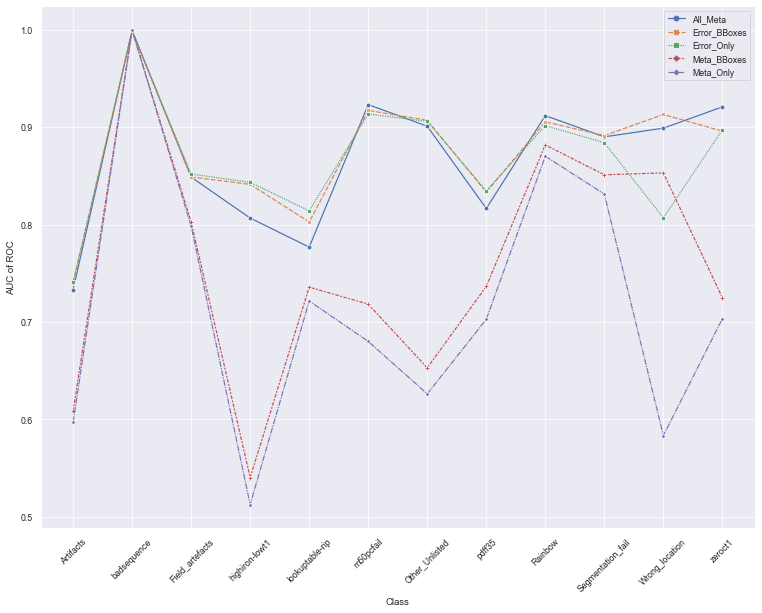

In [110]:
import seaborn as sns
import pandas as pd

loadDir = "./models/Random Forests/"

rfList = os.listdir(loadDir)

fullDict = {}
for fol in rfList:
    fullDict[fol] = {}
    with open(os.path.join(loadDir,fol,"metrics.json")) as f:
        metrics = json.load(f)
    for k1 in metrics.keys():
        avgAUC = []
        for k2 in metrics[k1].keys():
            avgAUC.append(metrics[k1][k2])
        fullDict[fol][k1] = np.mean(avgAUC)

df = pandas.DataFrame(fullDict)
print(df)

plt.figure()
sns.lineplot(data=df,markers=True)
plt.xlabel("Class")
plt.ylabel("AUC of ROC")
plt.xticks(rotation=45)
plt.show()

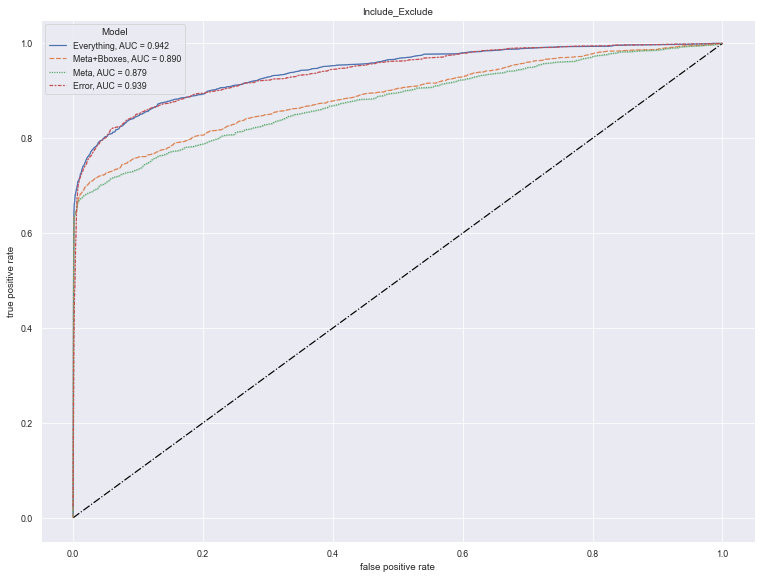

In [80]:
x0, y0 = ownDataset

newY = np.zeros(y0.shape[0])
for i in range(y0.shape[0]):
    if np.sum(y0[i,:]) >= 1:
        newY[i] = 1

y0 = newY

modelsArr = []
fprArr = []
tprArr = []
clfDict = {}

names = ["Everything","Meta+Bboxes","Meta","Error"]
features = [(0,-1),(0,-errFlat.shape[1]),(0,-(16+errFlat.shape[1])),(-errFlat.shape[1],-1)]

for name,(m,n) in zip(names,features):
    clf = RandomForestClassifier(n_estimators=100,max_depth=10,verbose=False,n_jobs=-1)

    y = y0
    if n == -1:
        X = x0[:,m:]
    else:
        X = x0[:,m:n]

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.4,random_state=42)

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    probs = clf.predict_proba(X_test)

    fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
    auc_score = roc_auc_score(y_test,probs[:,1])

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    clfDict[name] = clf

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("Include_Exclude")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

# Feature Importance:

In [114]:

featuresPlot = {}
for name in tagNames:
    featuresPlot[name] = []

for idx,name in enumerate(tagNames):
    print("#"*50)
    print(name)
    print("#"*50)

    clf = clfDict[name]
    instCnt = 0
    featCnt = -1
    for i,fImp in enumerate(clf.feature_importances_):
        if i % 7 == 0:
            instCnt = 0
            featCnt += 1
        if fImp > 0.005:
            featuresPlot[name].append((keysOI[featCnt],instTime[instCnt]))
            print("{},\t {}, \t\t\t {}".format(keysOI[featCnt],instTime[instCnt],fImp))
        instCnt += 1
    print("#"*50)


ow Center,	 4, 			 0.015494292261215955
Window Center,	 5, 			 0.0173415941186911
Window Center,	 6, 			 0.013309393341318324
Window Center,	 7, 			 0.013768866234141341
Window Width,	 1, 			 0.01588457211582732
Window Width,	 2, 			 0.013126385761925409
Window Width,	 3, 			 0.015788320586730933
Window Width,	 4, 			 0.01545877565569328
Window Width,	 5, 			 0.020838551822114776
Window Width,	 6, 			 0.015012918046396439
Window Width,	 7, 			 0.01272364318636624
##################################################
##################################################
Other_Unlisted
##################################################
Patient's Size,	 1, 			 0.00912997122375838
Patient's Size,	 2, 			 0.009305382988954376
Patient's Size,	 3, 			 0.011586999051560586
Patient's Size,	 4, 			 0.008556428550765374
Patient's Size,	 5, 			 0.008371799049111818
Patient's Size,	 6, 			 0.009882911630156442
Patient's Size,	 7, 			 0.013399231928476004
Patient's Weight,	 1, 			 0.012800646902411464
Pat

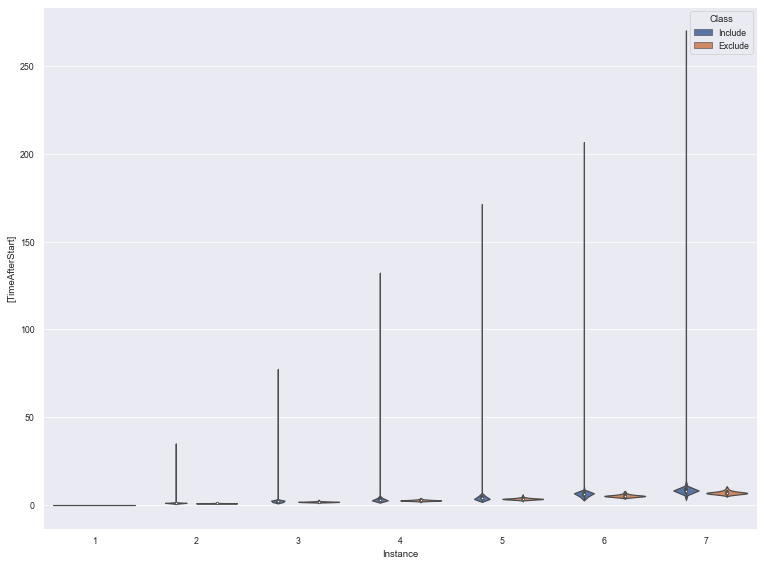

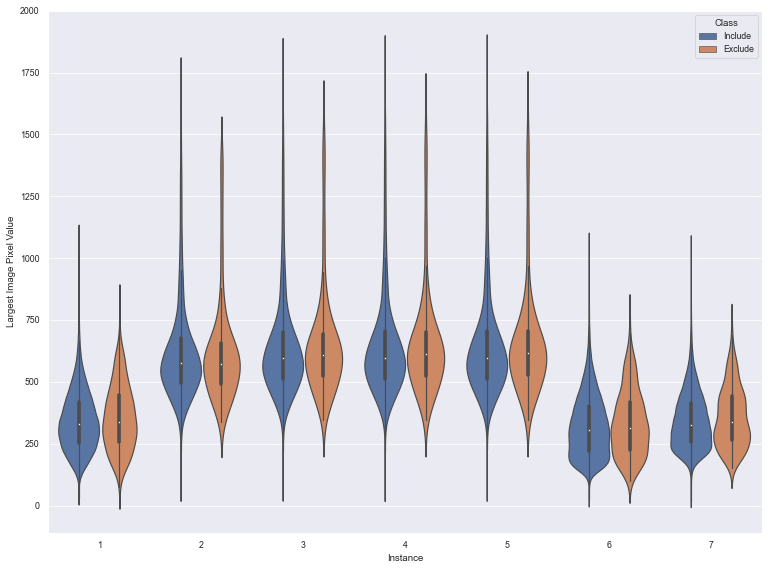

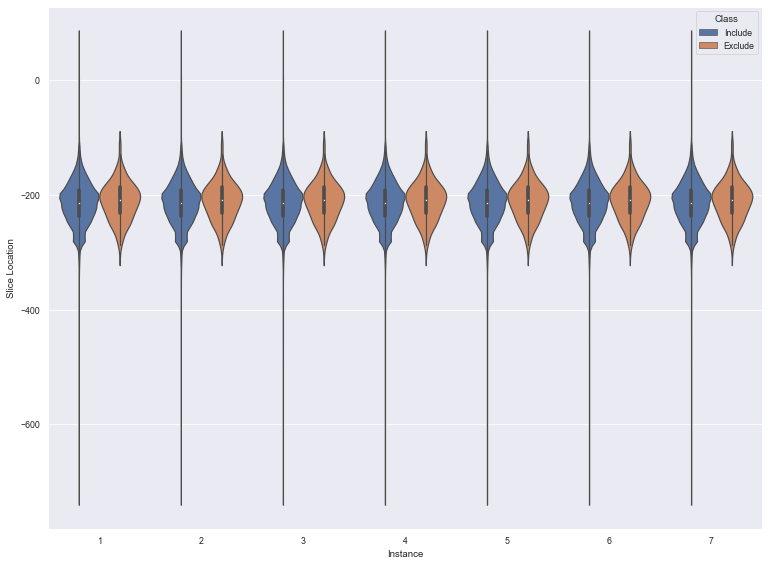

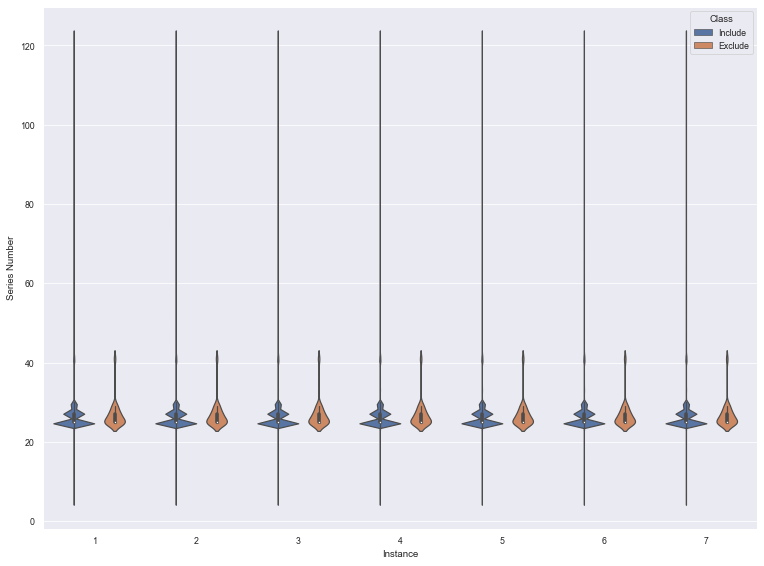

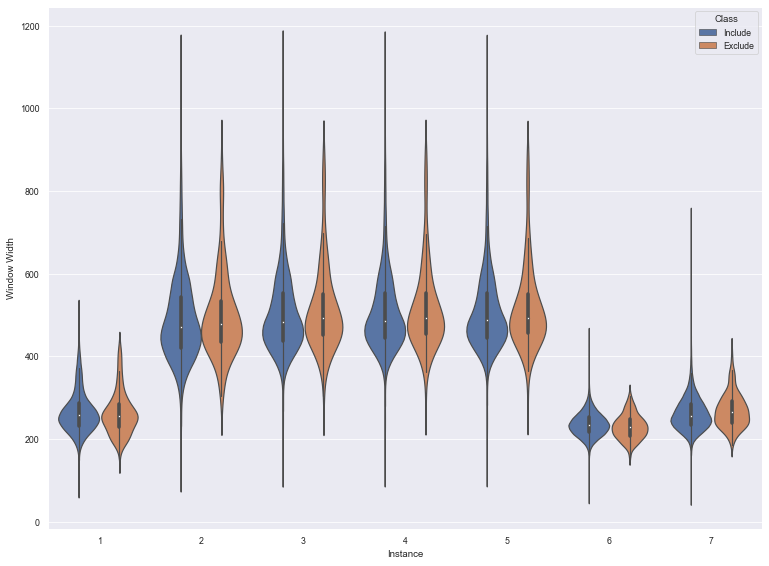

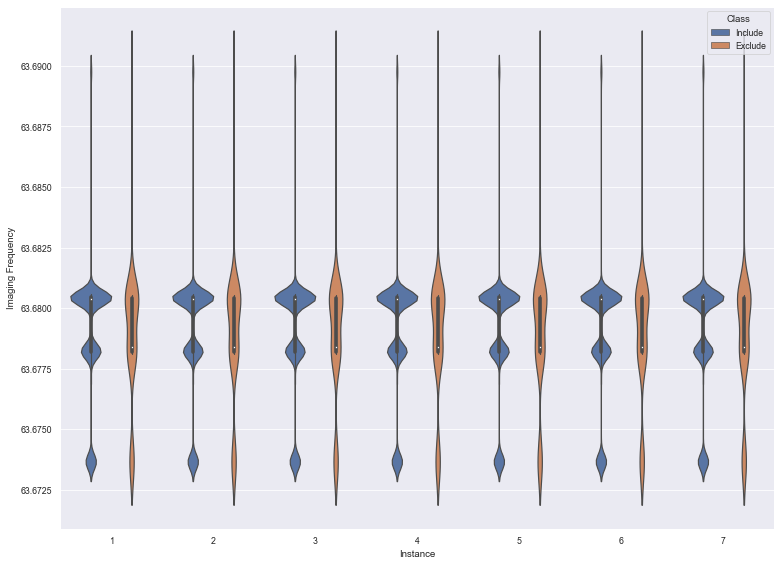

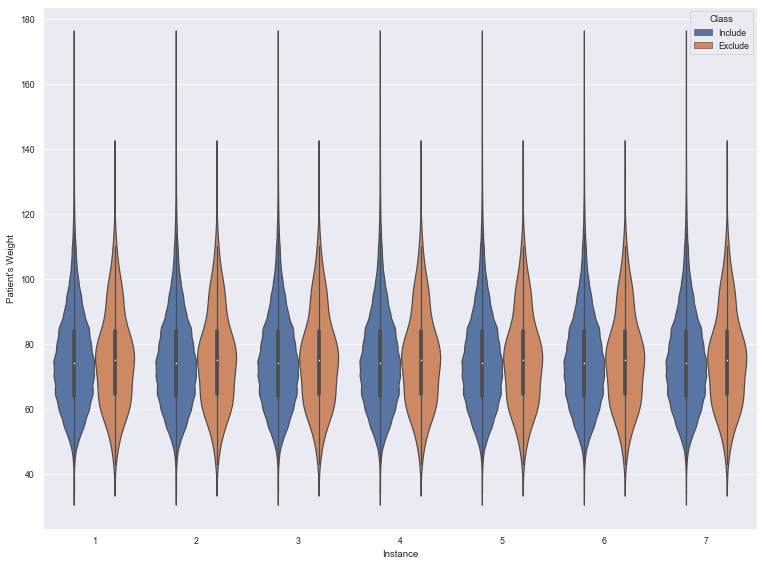

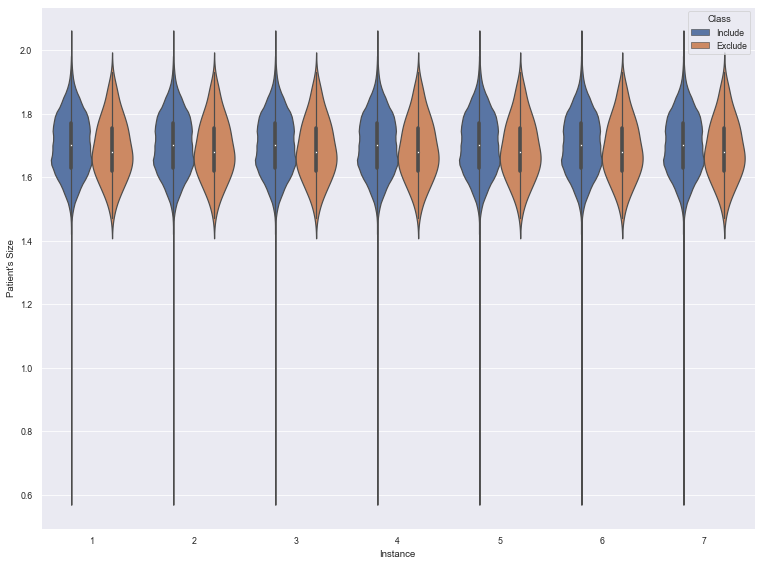

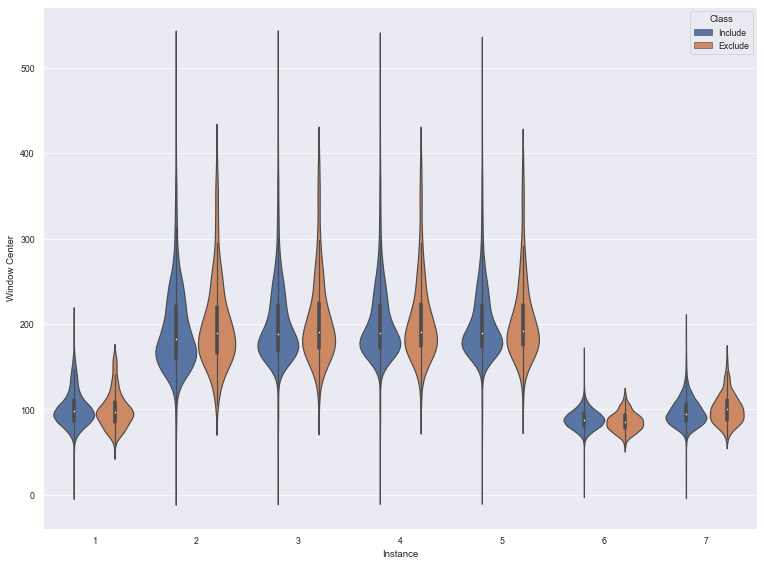

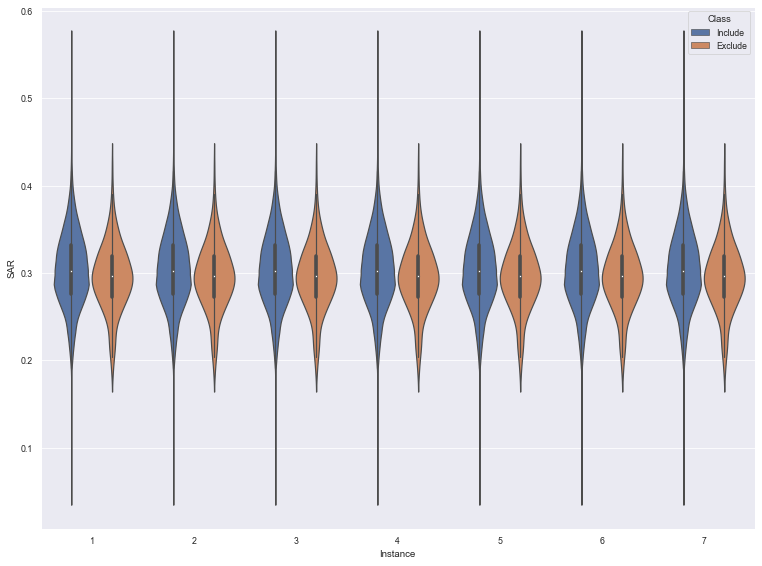

In [119]:
name = "Segmentation_fail"

features = [x[0] for x in featuresPlot['Artifacts']]
features = list(set(features))

for topFeature in features:
    metaList = []
    instTimeList = []
    tagListStr = []
    for i,k in enumerate(metaDict.keys()):
        for inst in instTime:
            instTimeList.append(inst)
            metaList.append(metaDict[k][inst][topFeature])
            if k in tagDict.keys():
                issues = tagDict[k]
                if issues[idx] == 1:
                    tagListStr.append("Exclude")
                else:
                    tagListStr.append("Include")
            else:
                tagListStr.append("Include")

    d = {topFeature:metaList,"Instance":instTimeList,"Class":tagListStr}
    df = pandas.DataFrame(data=d)

    sns.violinplot(x="Instance",y=topFeature,hue="Class",split=False,data=df)
    plt.show()
